In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('house_prices_with_missing.csv')

In [128]:
import seaborn as sns
import matplotlib.pyplot as plt
#fonction d'affichage des valeurs manquantes

def Affichage_graphe(imputation,methode) :

    print(f"Resumé des valeurs manquantes par {methode}")
    print(imputation.isnull().sum())

    #heatmap des valeurs manaquantes 
    plt.figure(figsize=(10,5))
    sns.heatmap(imputation.isnull(), cbar=False, cmap="viridis")
    plt.title(f"Valeurs manquantes par variables apres {methode} ")
    plt.show()

In [163]:
def regression_evaluation(df_impute, imputation_name, target_col='prix_vente', test_size=0.2, random_state=42):
    """
    Applique plusieurs modèles de régression avancés sur un DataFrame imputé,
    affiche les métriques et visualisations, et retourne un DataFrame résumé des scores.
    
    Args:
        df_impute (pd.DataFrame): DataFrame imputé.
        imputation_name (str): Nom de la méthode d'imputation (pour les titres).
        target_col (str): Nom de la variable cible.
        test_size (float): Proportion pour le test set.
        random_state (int): Graine aléatoire pour la reproductibilité.
        
    Returns:
        pd.DataFrame: Résumé des scores pour chaque modèle.
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.model_selection import train_test_split
    from sklearn.svm import SVR
    from sklearn.ensemble import GradientBoostingRegressor
    from sklearn.neighbors import KNeighborsRegressor
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    from sklearn.preprocessing import StandardScaler

    # Optionnel : XGBoost
    try:
        from xgboost import XGBRegressor
        xgb_available = True
    except ImportError:
        xgb_available = False

    # Encodage de la variable catégorielle si besoin
    df_model = df_impute.copy()
    for col in df_model.select_dtypes(include='object').columns:
        if col != target_col:
            df_model[col] = df_model[col].astype('category').cat.codes

    X = df_model.drop(target_col, axis=1)
    y = df_model[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Redimensionnement (scaling) pour SVR et KNN
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    models = {
        "SVR": SVR(),
        "GradientBoosting": GradientBoostingRegressor(random_state=random_state),
        "KNeighbors": KNeighborsRegressor(),
        "DecisionTree": DecisionTreeRegressor(random_state=random_state)
    }
    if xgb_available:
        models["XGBoost"] = XGBRegressor(random_state=random_state, verbosity=0)

    results = []
    for name, model in models.items():
        # Utiliser les données standardisées pour SVR et KNN, les données brutes pour les autres
        if name in ["SVR", "KNeighbors"]:
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        results.append({'Imputation': imputation_name, 'Modèle': name, 'MAE': mae, 'RMSE': rmse, 'R2': r2})

        # Visualisations
        residuals = y_test - y_pred
        plt.figure(figsize=(12,4))
        plt.subplot(1,2,1)
        sns.histplot(residuals, kde=True, bins=30, color='orange')
        plt.title(f"Résidus ({name} - {imputation_name})")
        plt.xlabel("Résidu")
        plt.ylabel("Fréquence")

        plt.subplot(1,2,2)
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        plt.title(f"y_test vs y_pred ({name} - {imputation_name})")
        plt.xlabel("y_test (réel)")
        plt.ylabel("y_pred (prédit)")
        plt.tight_layout()
        plt.show()

        print(f"{imputation_name} | {name} : MAE={mae:.2f}, RMSE={rmse:.2f}, R2={r2:.3f}")

    return pd.DataFrame(results)



In [32]:
df.head()

,surface_m2,n_chambres,n_sdb,annee_construction,quartier,prix_vente
0,114.901425,1.0,1.0,1971.0,D,224113.48
1,95.852071,1.0,4.0,2003.0,D,192102.28
2,119.430656,1.0,1.0,1955.0,D,222503.53
3,NaN,4.0,3.0,1999.0,E,301411.15
4,92.975399,4.0,2.0,1970.0,A,301053.92


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   surface_m2          9500 non-null   float64
 1   n_chambres          9700 non-null   float64
 2   n_sdb               9800 non-null   float64
 3   annee_construction  9600 non-null   float64
 4   quartier            9900 non-null   object 
 5   prix_vente          10000 non-null  float64
dtypes: float64(5), object(1)
memory usage: 468.9+ KB


In [34]:
print("Resumé des valeurs manquantes.")
print(df.isnull().sum())

Resumé des valeurs manquantes.
surface_m2            500
n_chambres            300
n_sdb                 200
annee_construction    400
quartier              100
prix_vente              0
dtype: int64


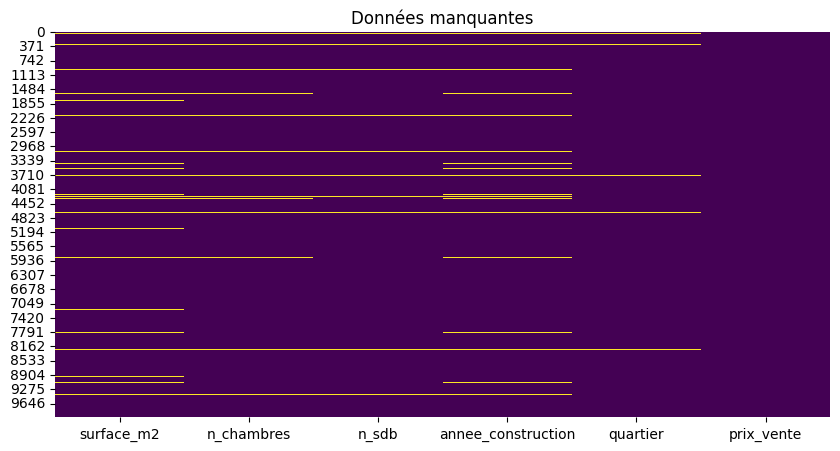

In [35]:
import seaborn as sns
plt.figure(figsize=(10,5))
sns.heatmap(df.isnull(), cbar=False , cmap="viridis")
plt.title("Données manquantes")
plt.show()

# LES IMPUTATIONS

In [169]:
num_cols = ['surface_m2', 'n_chambres', 'n_sdb', 'annee_construction']
cat_cols = ['quartier']

# IMPUTATION PAR MOYENNE #


In [ ]:
df_mean = df.copy()

In [158]:
from sklearn.impute import SimpleImputer
# Imputer la moyenne pour les variables numériques
imputer_mean = SimpleImputer(strategy='mean')
df_mean[num_cols] = imputer_mean.fit_transform(df_mean[num_cols])

# Imputer le mode pour la variable catégorielle
imputer_mode = SimpleImputer(strategy='most_frequent')
df_mean[cat_cols] = imputer_mode.fit_transform(df_mean[cat_cols])


Resumé des valeurs manquantes par imputation à la moyenne
surface_m2            0
n_chambres            0
n_sdb                 0
annee_construction    0
quartier              0
prix_vente            0
dtype: int64


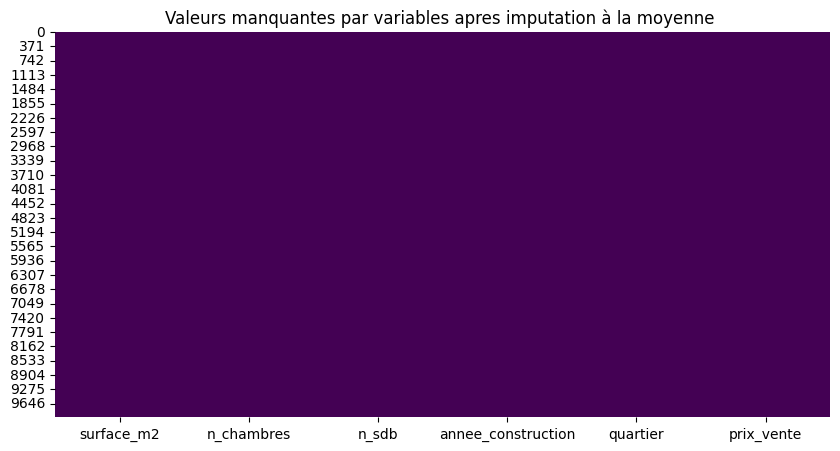

In [159]:
Affichage_graphe(df_mean, "imputation à la moyenne")

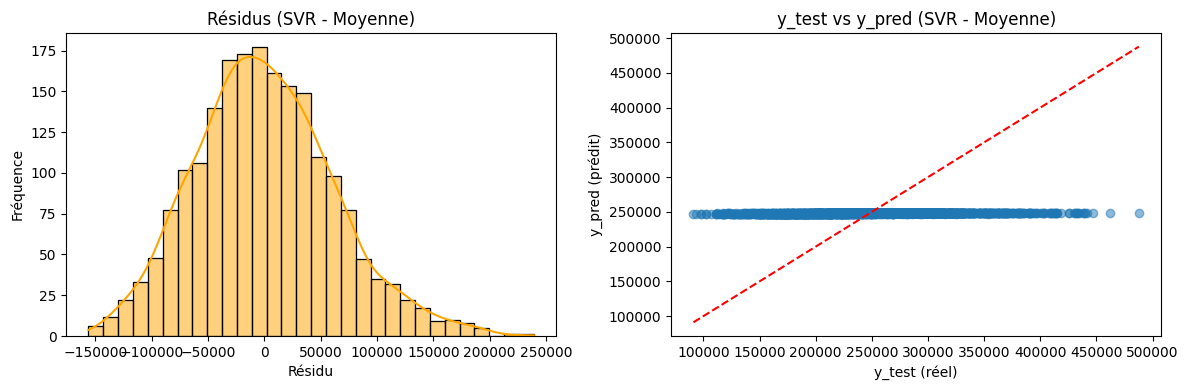

Moyenne | SVR : MAE=48875.54, RMSE=61679.15, R2=0.010


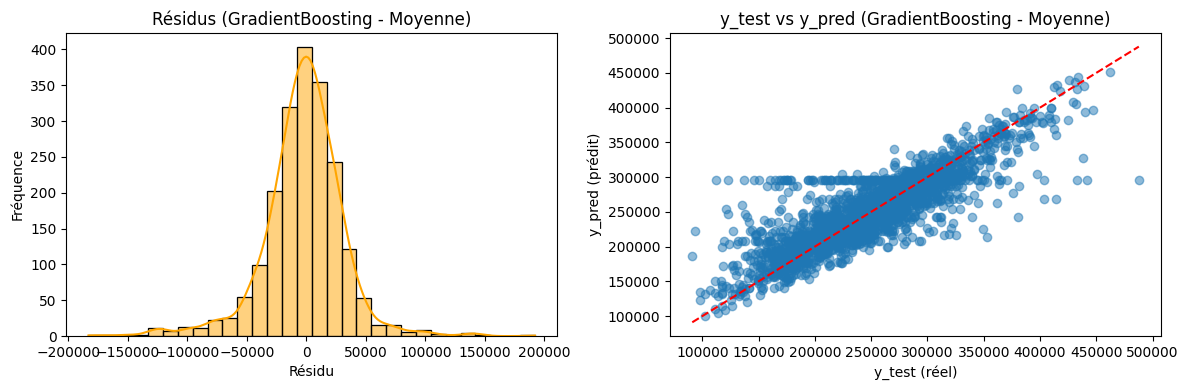

Moyenne | GradientBoosting : MAE=23492.01, RMSE=33649.51, R2=0.705


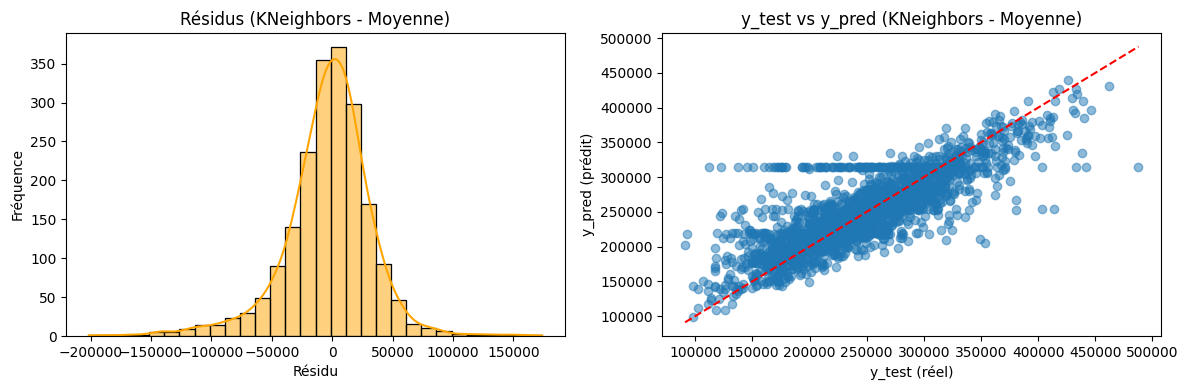

Moyenne | KNeighbors : MAE=25767.37, RMSE=36580.72, R2=0.652


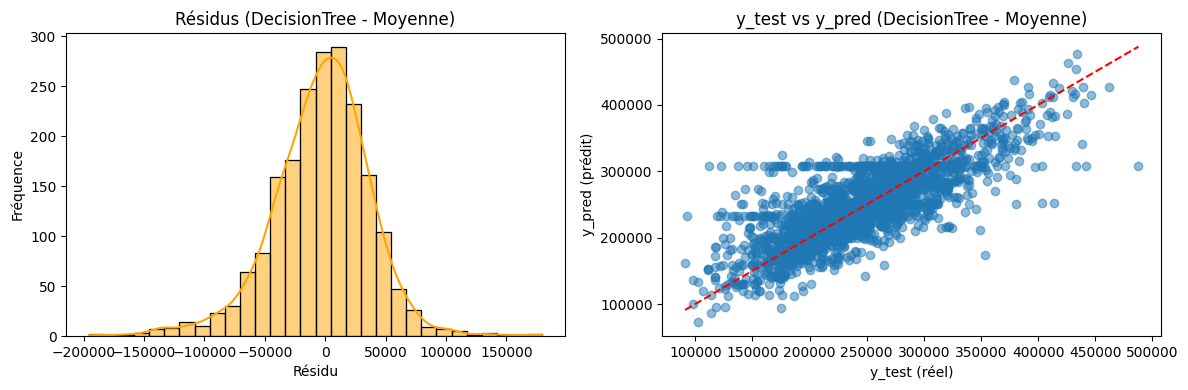

Moyenne | DecisionTree : MAE=30377.75, RMSE=40611.77, R2=0.571


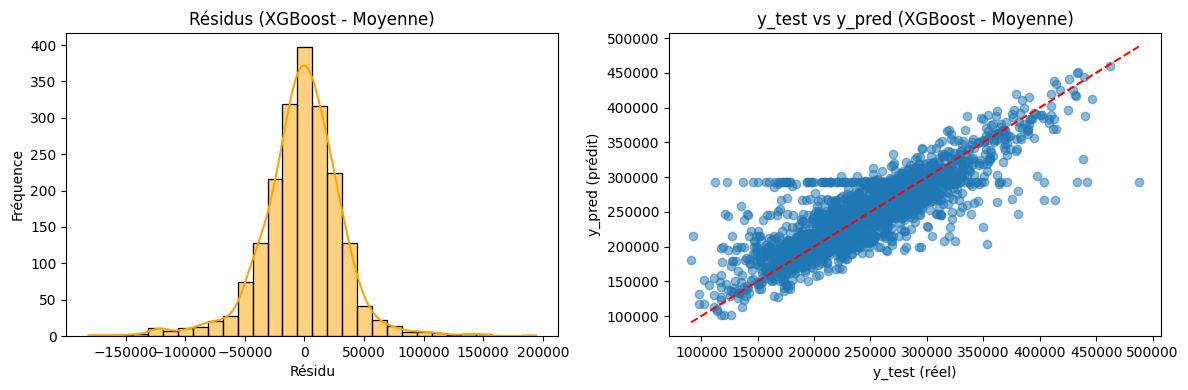

Moyenne | XGBoost : MAE=24264.00, RMSE=34208.79, R2=0.695


,Imputation,Modèle,MAE,RMSE,R2
0,Moyenne,SVR,48875.539373,61679.148241,0.009643
1,Moyenne,GradientBoosting,23492.014655,33649.511214,0.705237
2,Moyenne,KNeighbors,25767.372680,36580.716572,0.651647
3,Moyenne,DecisionTree,30377.745820,40611.772956,0.570643
4,Moyenne,XGBoost,24264.000521,34208.790025,0.695357


In [164]:
regression_evaluation(df_mean, "Moyenne")

# IMPUTATION PAR LA MEDIANE

In [130]:
df_median = df.copy()

# Imputer la médiane pour les variables numériques
imputer_median = SimpleImputer(strategy='median')
df_median[num_cols] = imputer_median.fit_transform(df_median[num_cols])

# Imputer le mode pour la variable catégorielle
imputer_mode = SimpleImputer(strategy='most_frequent')
df_median[cat_cols] = imputer_mode.fit_transform(df_median[cat_cols])


Resumé des valeurs manquantes par imputation à la médiane
surface_m2            0
n_chambres            0
n_sdb                 0
annee_construction    0
quartier              0
prix_vente            0
dtype: int64


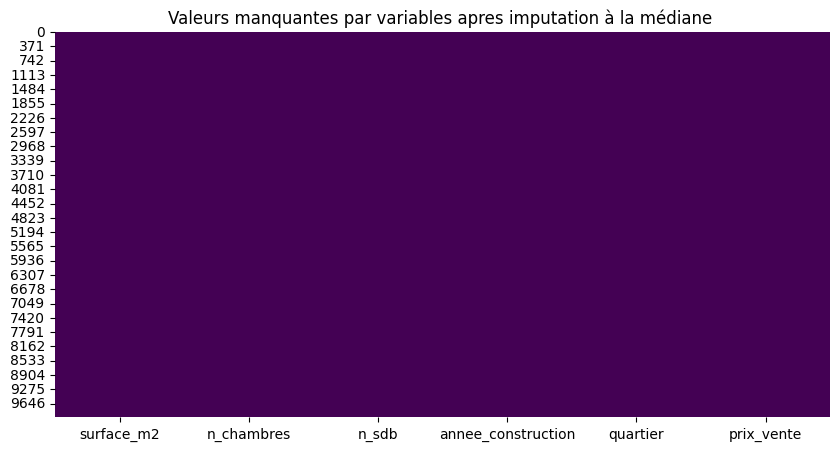

In [131]:
Affichage_graphe(df_median, "imputation à la médiane")

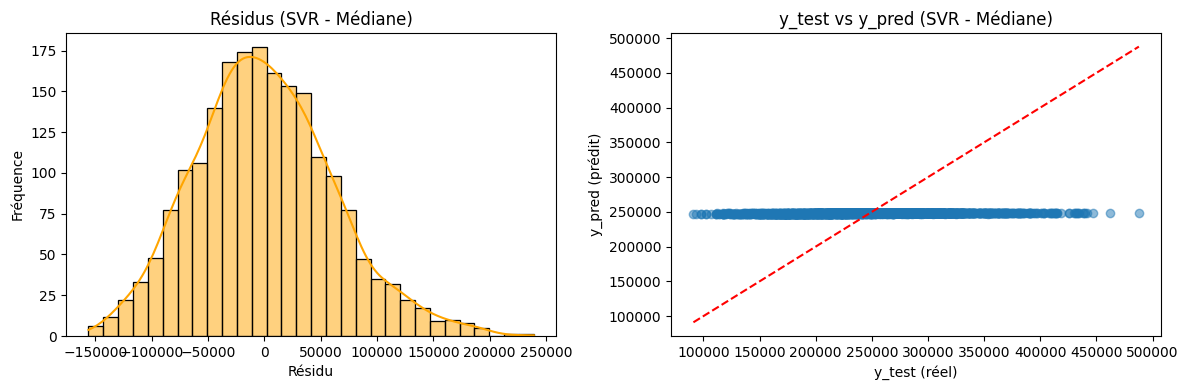

Médiane | SVR : MAE=48875.44, RMSE=61678.96, R2=0.010


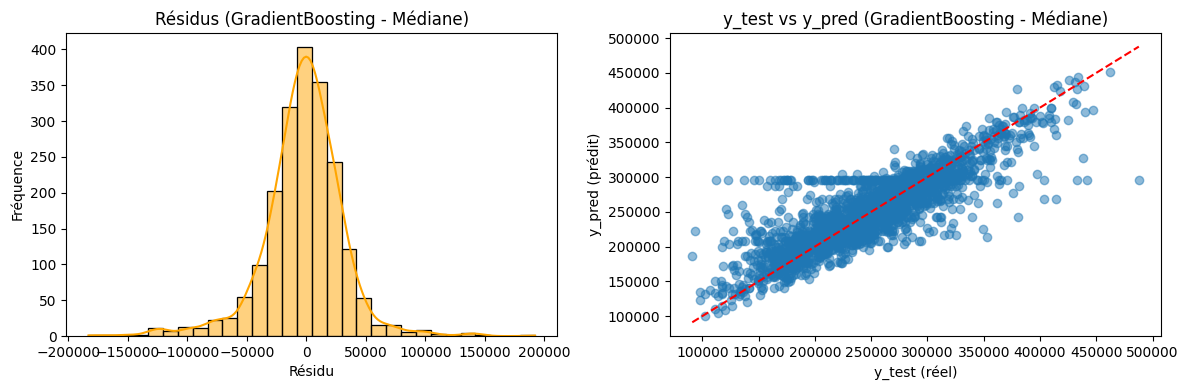

Médiane | GradientBoosting : MAE=23492.01, RMSE=33649.51, R2=0.705


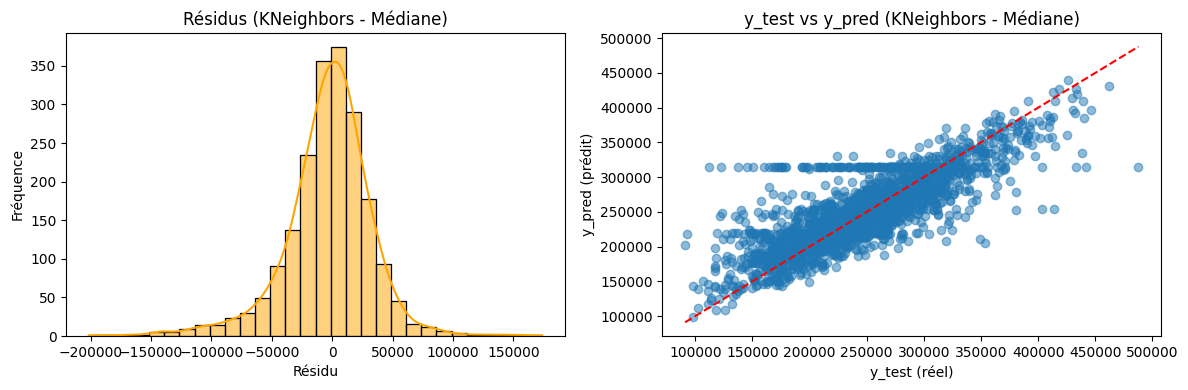

Médiane | KNeighbors : MAE=25798.76, RMSE=36563.61, R2=0.652


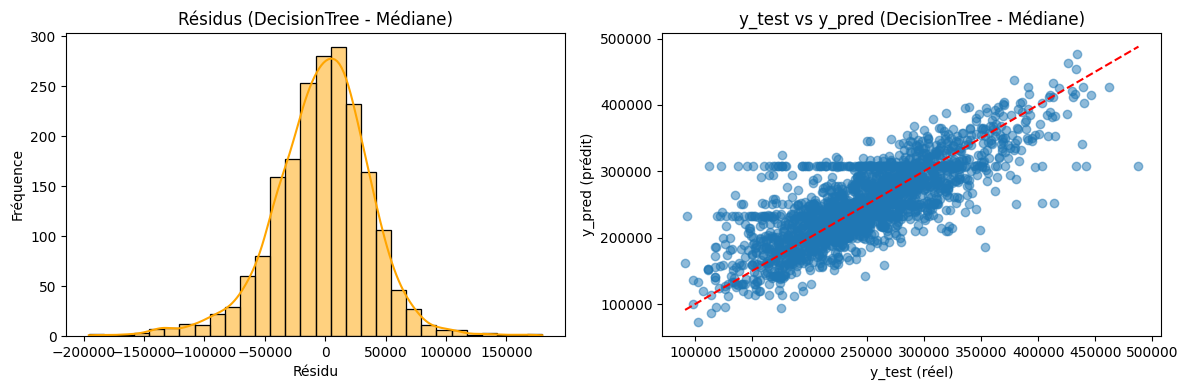

Médiane | DecisionTree : MAE=30249.06, RMSE=40391.65, R2=0.575


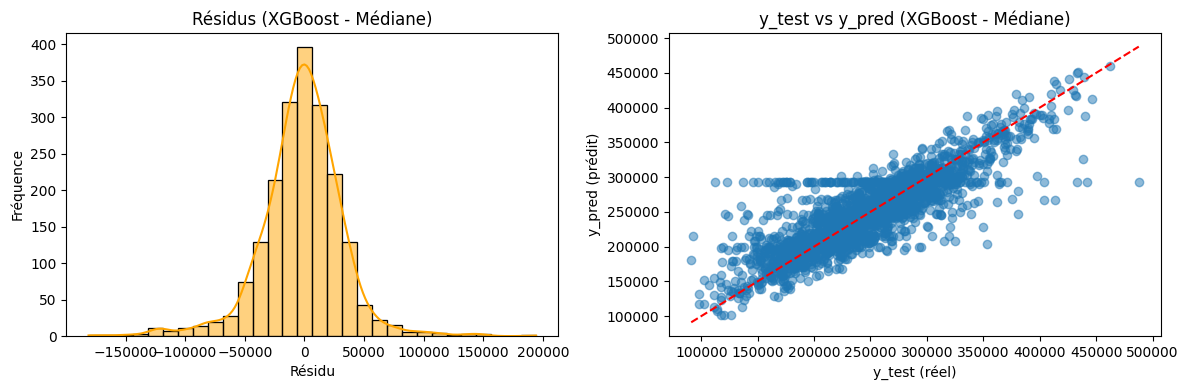

Médiane | XGBoost : MAE=24263.17, RMSE=34211.61, R2=0.695


,Imputation,Modèle,MAE,RMSE,R2
0,Médiane,SVR,48875.443368,61678.963136,0.009649
1,Médiane,GradientBoosting,23492.014655,33649.511214,0.705237
2,Médiane,KNeighbors,25798.755557,36563.605089,0.651973
3,Médiane,DecisionTree,30249.061475,40391.645251,0.575284
4,Médiane,XGBoost,24263.166631,34211.614885,0.695307


In [165]:
regression_evaluation(df_median, "Médiane")

# IMPUTATION PAR MODE

In [133]:
df_mode = df.copy()

# Imputer le mode pour toutes les colonnes (numériques et catégorielles)
imputer_mode = SimpleImputer(strategy='most_frequent')
df_mode[num_cols + cat_cols] = imputer_mode.fit_transform(df_mode[num_cols + cat_cols])


Resumé des valeurs manquantes par imputation par le mode
surface_m2            0
n_chambres            0
n_sdb                 0
annee_construction    0
quartier              0
prix_vente            0
dtype: int64


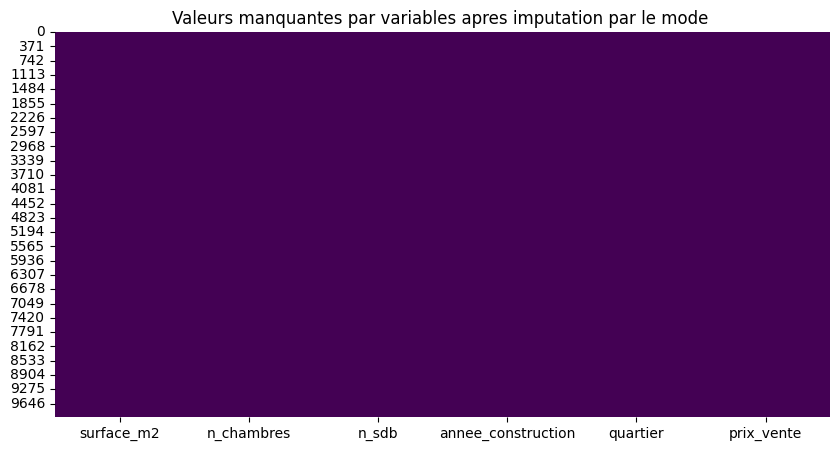

In [134]:
Affichage_graphe(df_mode, "imputation par le mode")

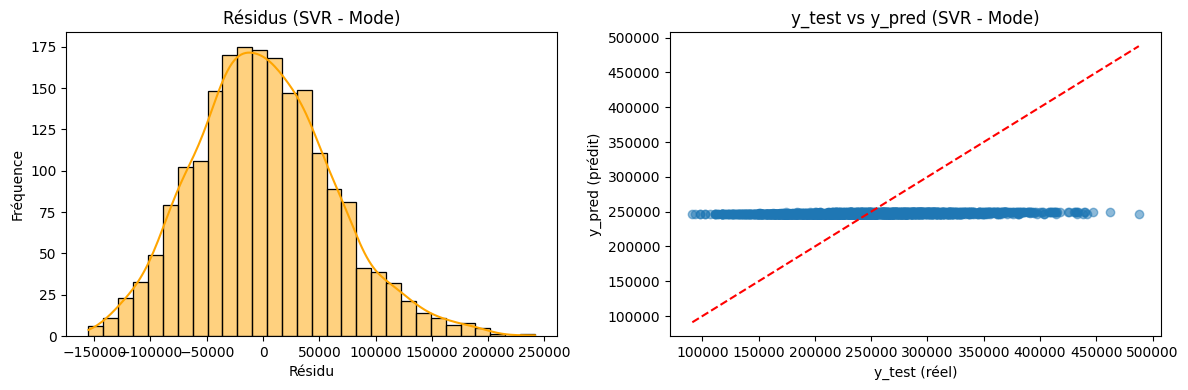

Mode | SVR : MAE=48641.96, RMSE=61392.95, R2=0.019


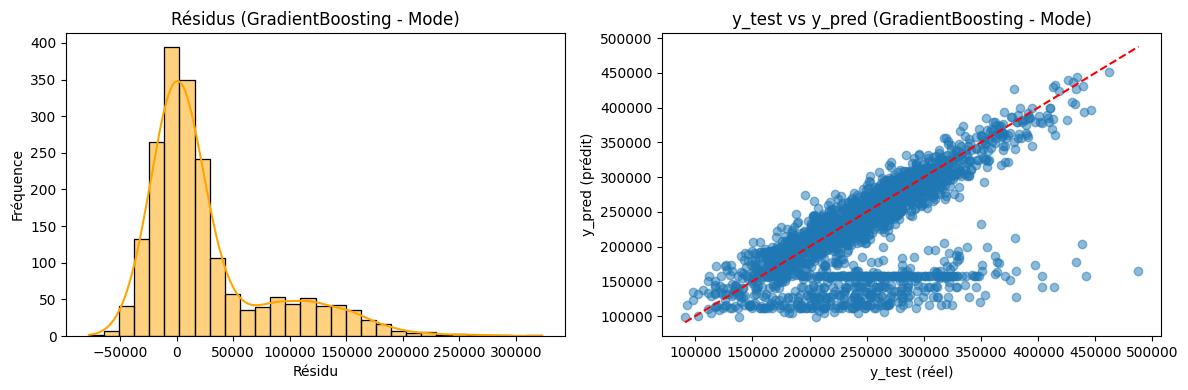

Mode | GradientBoosting : MAE=38355.04, RMSE=61422.65, R2=0.018


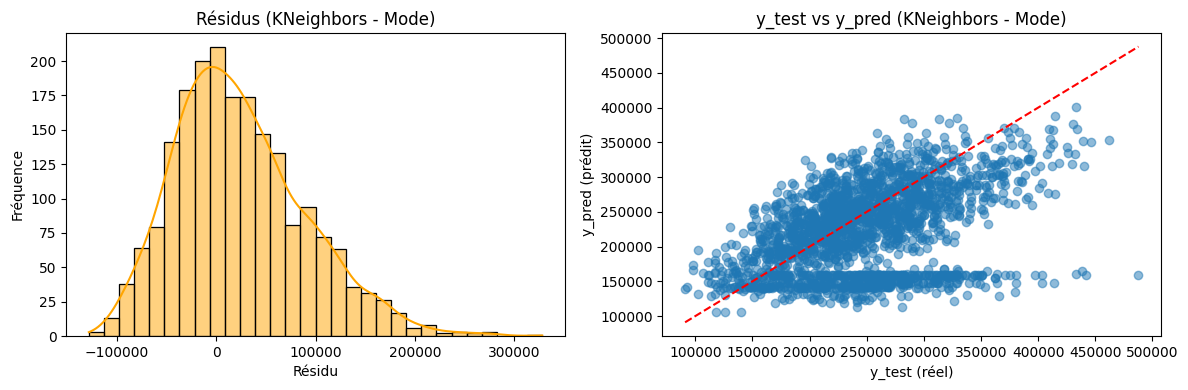

Mode | KNeighbors : MAE=53036.25, RMSE=69851.61, R2=-0.270


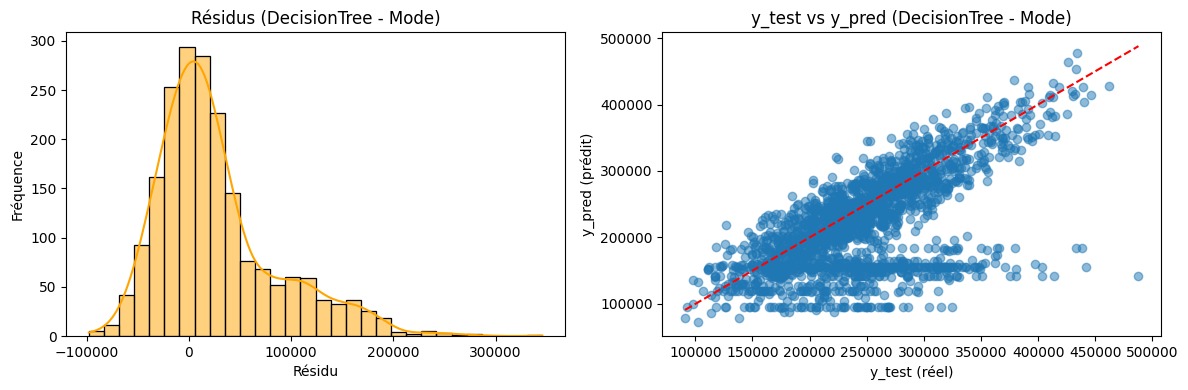

Mode | DecisionTree : MAE=44394.55, RMSE=64722.11, R2=-0.090


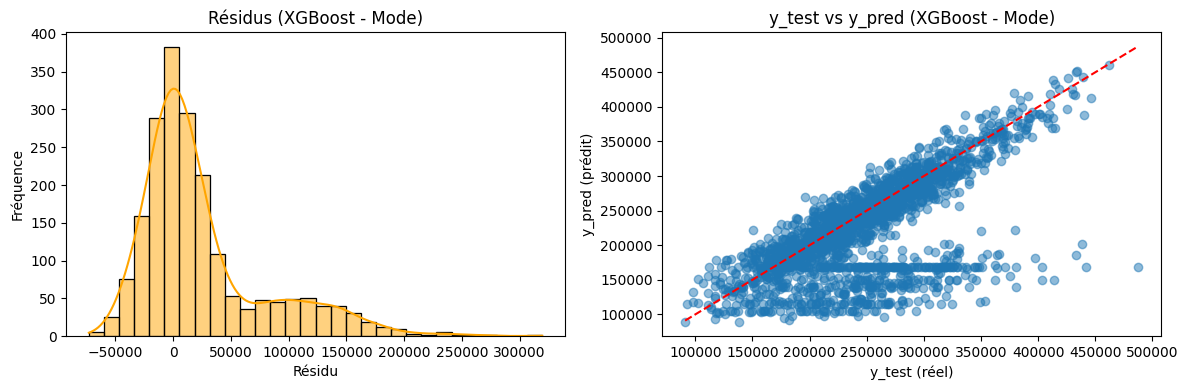

Mode | XGBoost : MAE=38322.89, RMSE=60147.58, R2=0.058


,Imputation,Modèle,MAE,RMSE,R2
0,Mode,SVR,48641.963512,61392.949125,0.018812
1,Mode,GradientBoosting,38355.044661,61422.654545,0.017863
2,Mode,KNeighbors,53036.251220,69851.609775,-0.270188
3,Mode,DecisionTree,44394.546530,64722.110958,-0.090487
4,Mode,XGBoost,38322.890348,60147.584853,0.058216


In [135]:
regression_evaluation(df_mode, "Mode")

# IMPUTATION KNN

In [144]:
df_knn = df.copy()

In [153]:
from sklearn.impute import KNNImputer

# Encodage de la variable catégorielle
df_knn['quartier'] = df_knn['quartier'].astype('category').cat.codes

# Application du KNNImputer
imputer_knn = KNNImputer(n_neighbors=5)
df_knn[num_cols + ['quartier']] = imputer_knn.fit_transform(df_knn[num_cols + ['quartier']])

# (Optionnel) Décodage de la variable catégorielle
quartier_mapping = dict(enumerate(df['quartier'].astype('category').cat.categories))
df_knn['quartier'] = df_knn['quartier'].round().astype(int).map(quartier_mapping)

In [162]:
df_knn.head()

,surface_m2,n_chambres,n_sdb,annee_construction,quartier,prix_vente
0,114.901425,1.0,1.0,1971.0,D,224113.48
1,95.852071,1.0,4.0,2003.0,D,192102.28
2,119.430656,1.0,1.0,1955.0,D,222503.53
3,107.010082,4.0,3.0,1999.0,E,301411.15
4,92.975399,4.0,2.0,1970.0,A,301053.92


In [161]:
df_knn.describe()

,surface_m2,n_chambres,n_sdb,annee_construction,prix_vente
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,100.230991,3.046720,2.114320,1985.735620,250433.066819
std,29.243405,1.628635,1.175363,20.448639,62260.798767
min,30.000000,1.000000,1.000000,1950.000000,62817.670000
25%,80.867285,2.000000,1.000000,1968.000000,206289.002500
50%,100.221080,3.000000,2.000000,1986.000000,247325.640000
75%,119.325114,4.000000,3.000000,2003.000000,289800.295000
max,217.787131,8.000000,5.000000,2021.000000,521199.630000


Resumé des valeurs manquantes par imputation KNN
surface_m2            0
n_chambres            0
n_sdb                 0
annee_construction    0
quartier              0
prix_vente            0
dtype: int64


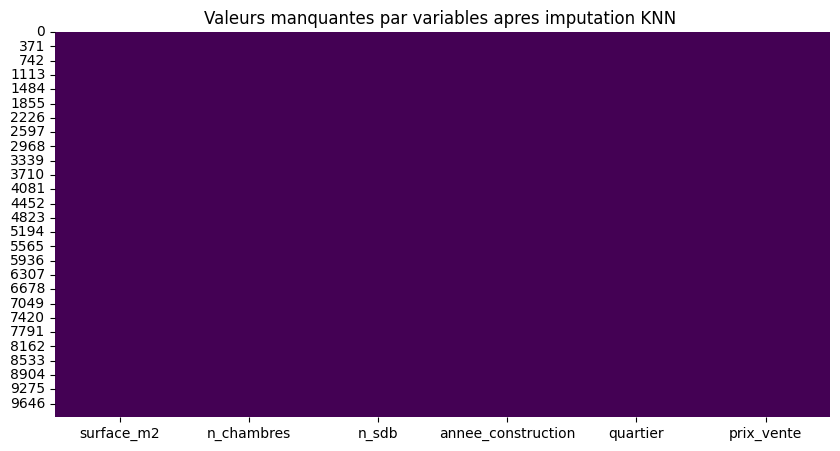

In [154]:
Affichage_graphe(df_knn, "imputation KNN")

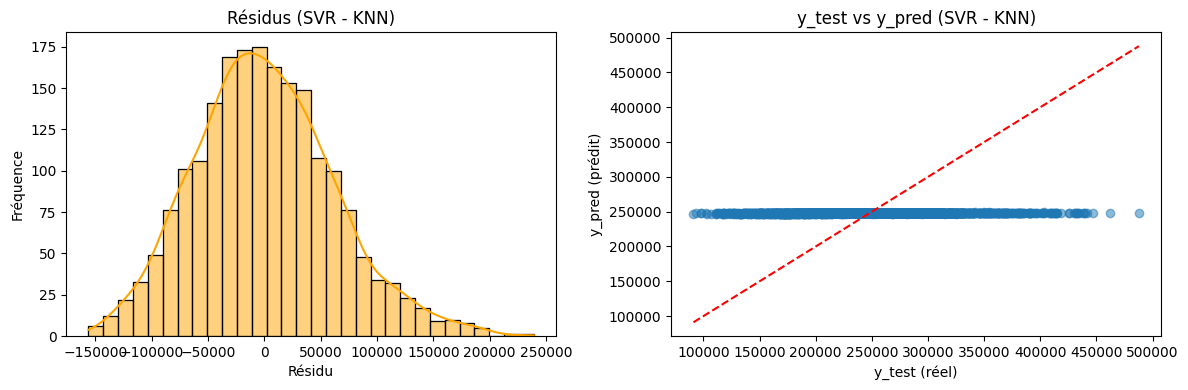

KNN | SVR : MAE=48880.35, RMSE=61683.53, R2=0.010


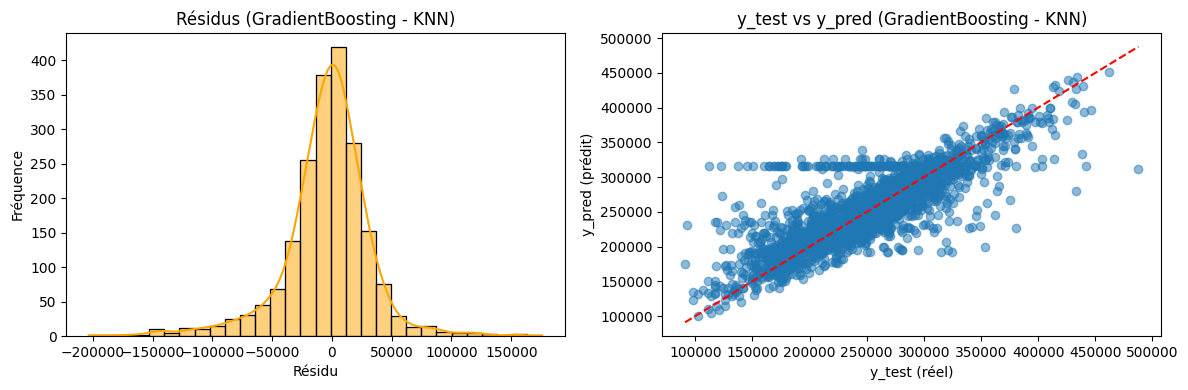

KNN | GradientBoosting : MAE=24787.63, RMSE=36570.76, R2=0.652


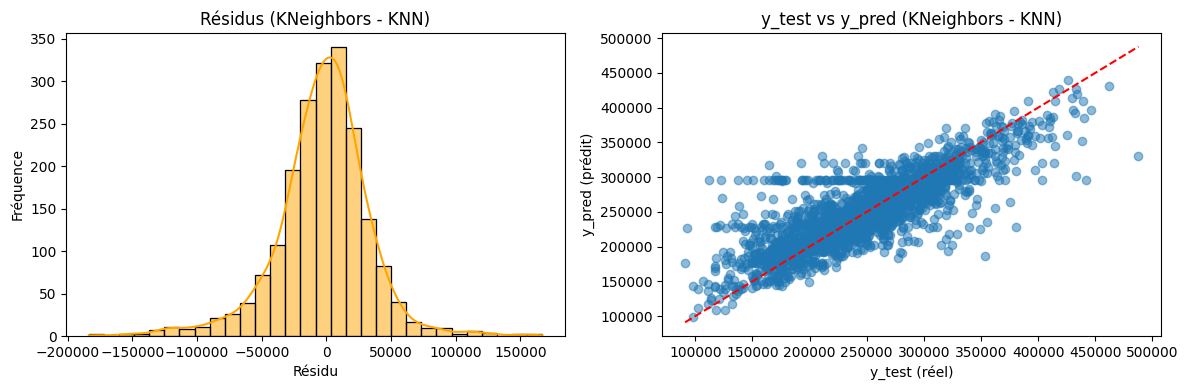

KNN | KNeighbors : MAE=25794.05, RMSE=36199.95, R2=0.659


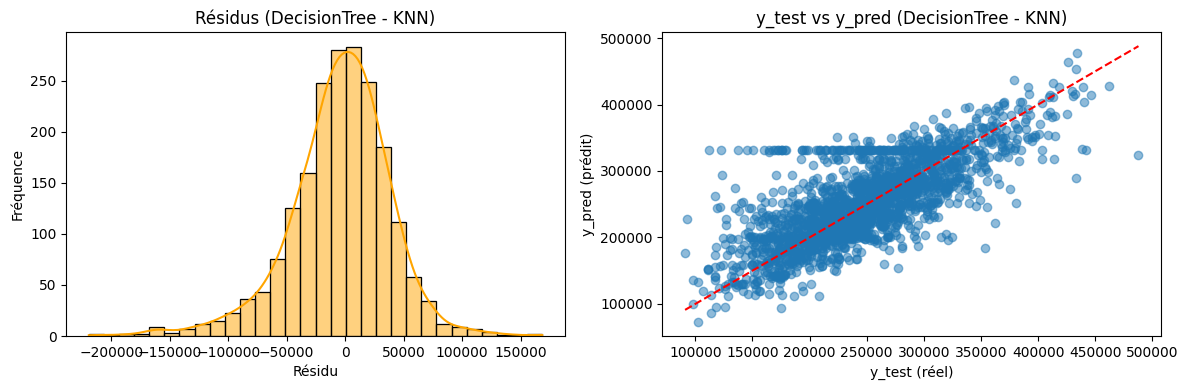

KNN | DecisionTree : MAE=32039.98, RMSE=43568.55, R2=0.506


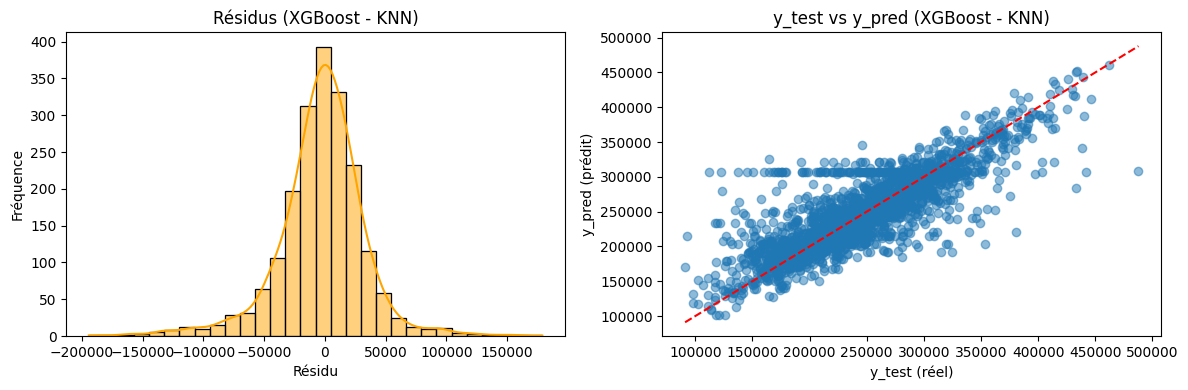

KNN | XGBoost : MAE=25267.16, RMSE=36341.76, R2=0.656


,Imputation,Modèle,MAE,RMSE,R2
0,KNN,SVR,48880.351982,61683.527495,0.009502
1,KNN,GradientBoosting,24787.629773,36570.761081,0.651837
2,KNN,KNeighbors,25794.051471,36199.953334,0.658861
3,KNN,DecisionTree,32039.980870,43568.549712,0.505847
4,KNN,XGBoost,25267.159324,36341.755586,0.656183


In [166]:
regression_evaluation(df_knn, "KNN")

In [53]:
# Copier le DataFrame
df_dropna = df.copy()

# Afficher les lignes contenant des valeurs manquantes (facultatif, juste pour info)
print("Lignes contenant des NaN :")
print(df_dropna[df_dropna.isnull().any(axis=1)])

# Nombre initial de lignes
n_before = df_dropna.shape[0]

# Supprimer les lignes avec au moins une valeur manquante
df_dropna = df_dropna.dropna()

# Nombre de lignes après suppression
n_after = df_dropna.shape[0]

# Calcul du ratio de suppression (arrondi à 2 chiffres après la virgule)
ratio_suppression = (n_before - n_after) / n_before

# Affichage des résultats
print(f"Lignes initiales           : {n_before}")
print(f"Lignes après suppression   : {n_after}")
print(f"Ratio de suppression       : {ratio_suppression:.2%}")

if ratio_suppression < 0.05 :
    print("Suppression faible (<5%) : généralement acceptable")
elif ratio_suppression < 0.2 :
    print("Suppression modéréee (5-20%) : Utiliser avec prudence, verifier l'impact sur les données.")
else :
    print("Suppression importante (>20%) : Deconseiller, préférer l'imputation.")


Lignes contenant des NaN :
      surface_m2  n_chambres  n_sdb  annee_construction quartier  prix_vente
3            NaN         4.0    3.0              1999.0        E   301411.15
14           NaN         1.0    1.0                 NaN        E    91104.38
29           NaN         NaN    NaN                 NaN        B   328111.17
31           NaN         NaN    NaN                 NaN        B   413800.73
33           NaN         NaN    NaN                 NaN        E   197151.65
...          ...         ...    ...                 ...      ...         ...
9783         NaN         NaN    4.0                 NaN        A   331036.13
9896         NaN         NaN    NaN                 NaN      NaN   261918.47
9909         NaN         1.0    5.0              1986.0        C   294957.46
9920         NaN         NaN    NaN                 NaN      NaN   175624.54
9930         NaN         NaN    NaN                 NaN      NaN   208910.38

[500 rows x 6 columns]
Lignes initiales         

In [54]:
#supprimer les lignes avec au moins une valeur manquante
df_dropna = df_dropna.dropna()

print(f"Nombre de lignes après suppression : {df_dropna.shape[0]}")

Nombre de lignes après suppression : 9500


Resumé des valeurs manquantes
surface_m2            0
n_chambres            0
n_sdb                 0
annee_construction    0
quartier              0
prix_vente            0
dtype: int64


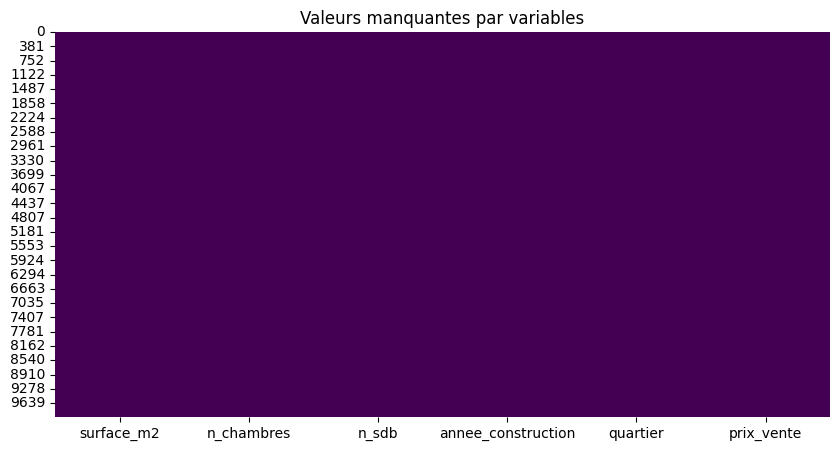

In [55]:
#Affichage des valeurs manquantes

print("Resumé des valeurs manquantes")
print(df_knn.isnull().sum())

#heatmap des valeurs manaquantes 
plt.figure(figsize=(10,5))
sns.heatmap(df_dropna.isnull(), cbar=False, cmap="viridis")
plt.title("Valeurs manquantes par variables")
plt.show()

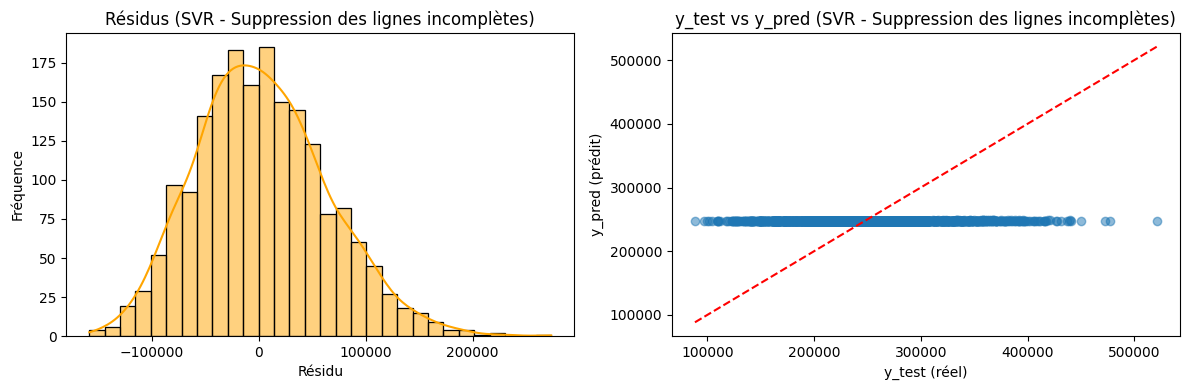

Suppression des lignes incomplètes | SVR : MAE=49056.25, RMSE=61632.01, R2=0.008


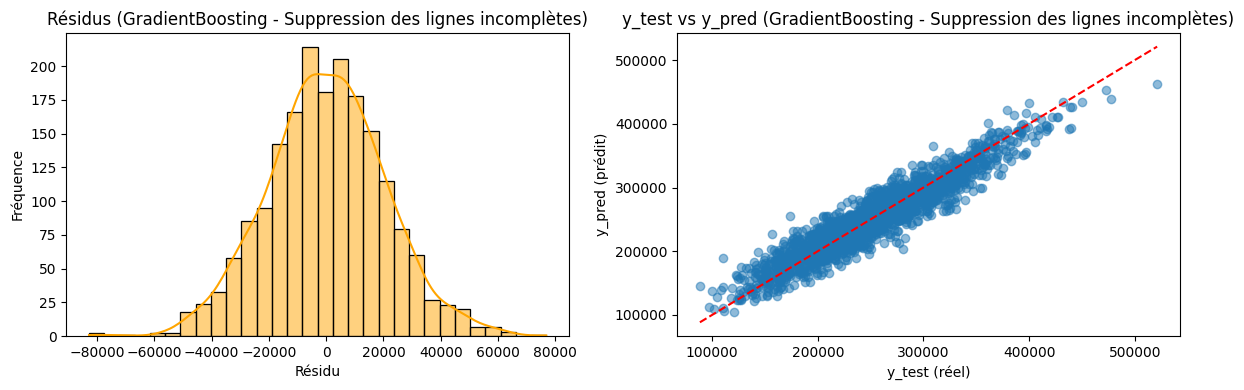

Suppression des lignes incomplètes | GradientBoosting : MAE=16229.15, RMSE=20544.68, R2=0.890


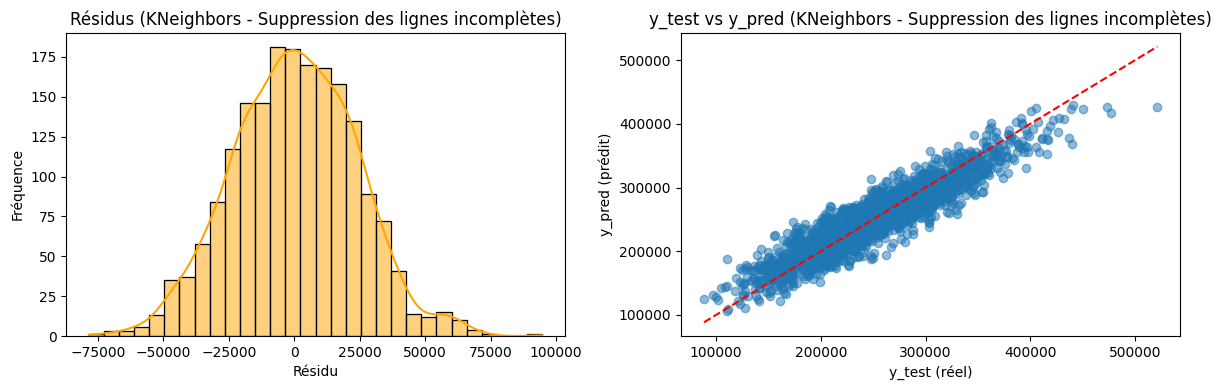

Suppression des lignes incomplètes | KNeighbors : MAE=18764.48, RMSE=23458.81, R2=0.856


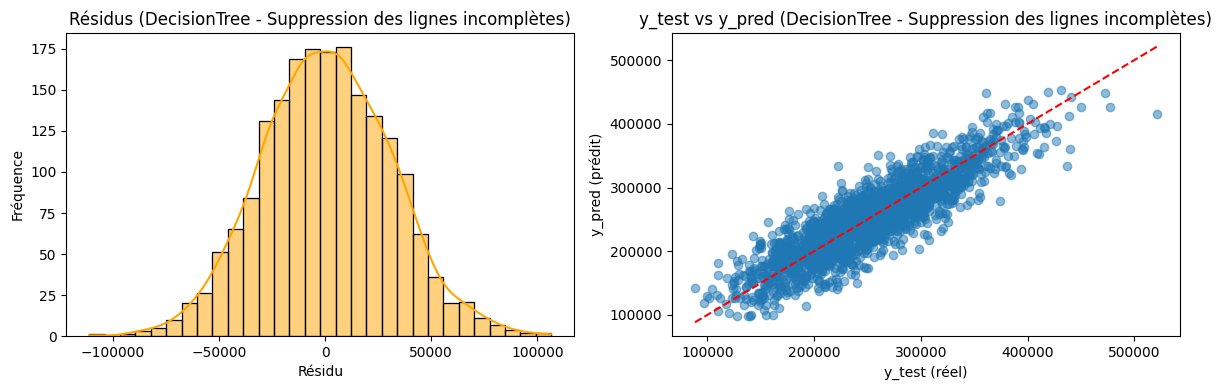

Suppression des lignes incomplètes | DecisionTree : MAE=24352.52, RMSE=30482.78, R2=0.757


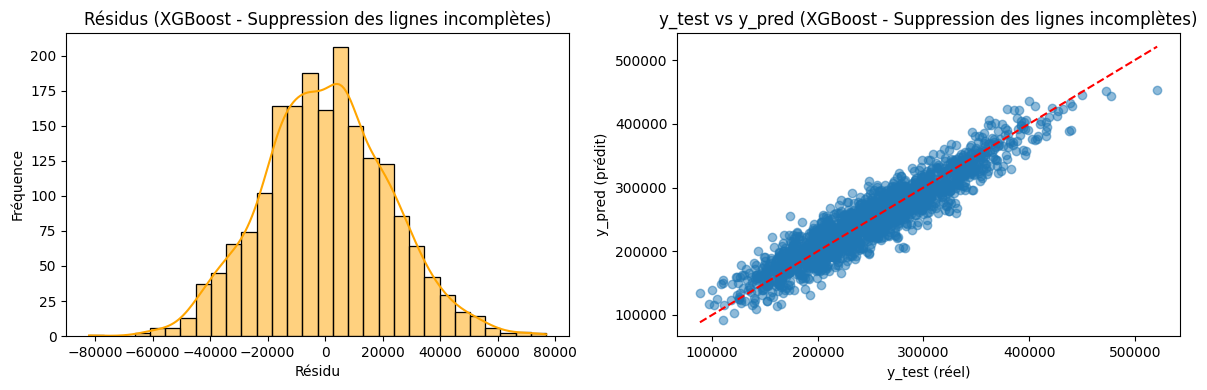

Suppression des lignes incomplètes | XGBoost : MAE=17472.43, RMSE=21930.48, R2=0.874


,Imputation,Modèle,MAE,RMSE,R2
0,Suppression des lignes incomplètes,SVR,49056.252358,61632.013989,0.007830
1,Suppression des lignes incomplètes,GradientBoosting,16229.154633,20544.680077,0.889752
2,Suppression des lignes incomplètes,KNeighbors,18764.476611,23458.806135,0.856258
3,Suppression des lignes incomplètes,DecisionTree,24352.516882,30482.778629,0.757293
4,Suppression des lignes incomplètes,XGBoost,17472.427461,21930.481173,0.874377


In [167]:
regression_evaluation(df_dropna, "Suppression des lignes incomplètes")

# IMPUTATION PAR REGRESSION 

In [57]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

df_reg = df.copy()

In [68]:
# Encodage temporaire de la variable catégorielle
df_reg['quartier'] = df_reg['quartier'].astype('category').cat.codes

# Application de l'imputation par régression
iter_imputer = IterativeImputer(random_state=0, max_iter=10)
df_reg[num_cols + ['quartier']] = iter_imputer.fit_transform(df_reg[num_cols + ['quartier']])

# Compléter l'imputation de 'quartier' par le mode
mode_quartier = df_reg['quartier'].mode()[0]
df_reg['quartier'] = df_reg['quartier'].fillna(mode_quartier)

In [69]:
# Vérification
print("Résumé des valeurs manquantes après imputation par régression :")
print(df_reg.isnull().sum())

Résumé des valeurs manquantes après imputation par régression :
surface_m2            0
n_chambres            0
n_sdb                 0
annee_construction    0
quartier              0
prix_vente            0
dtype: int64


Résumé des valeurs manquantes
surface_m2            0
n_chambres            0
n_sdb                 0
annee_construction    0
quartier              0
prix_vente            0
dtype: int64


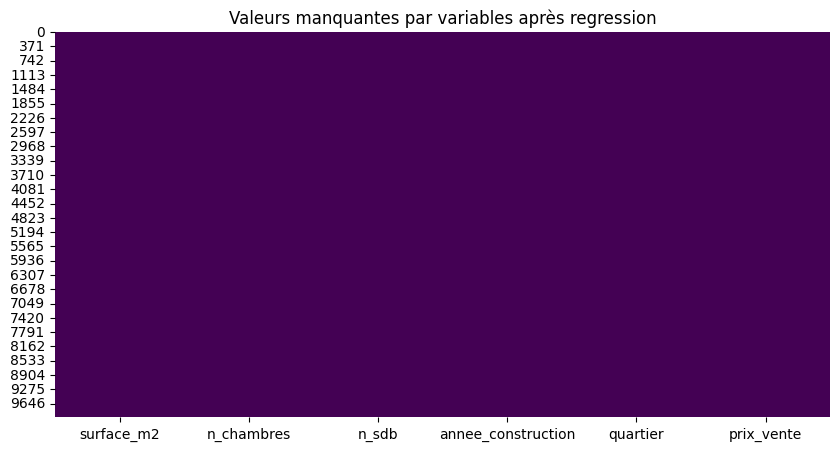

In [121]:
Affichage_graphe(df_reg,"regression")

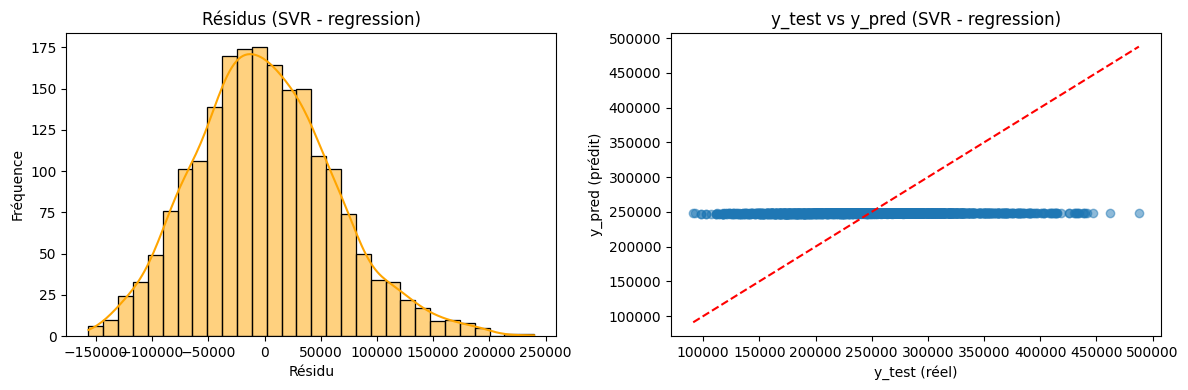

regression | SVR : MAE=48981.61, RMSE=61790.85, R2=0.006


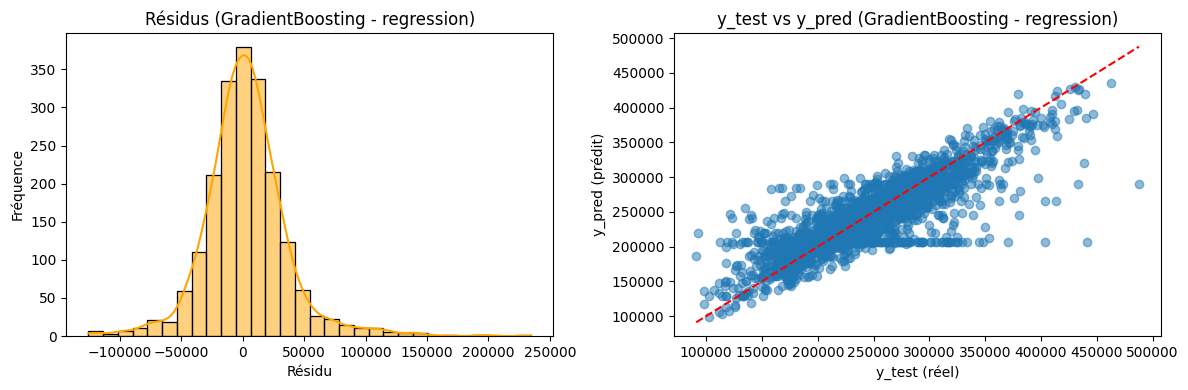

regression | GradientBoosting : MAE=23686.25, RMSE=33769.90, R2=0.703


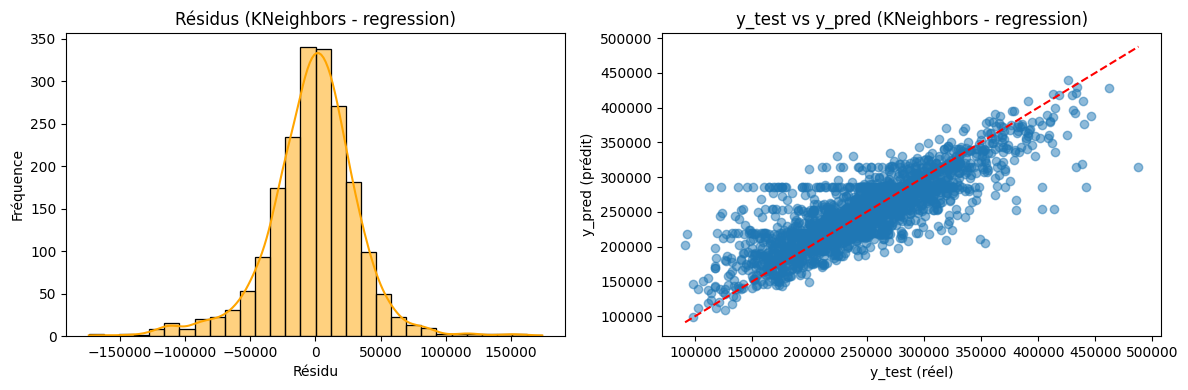

regression | KNeighbors : MAE=25044.66, RMSE=34864.12, R2=0.684


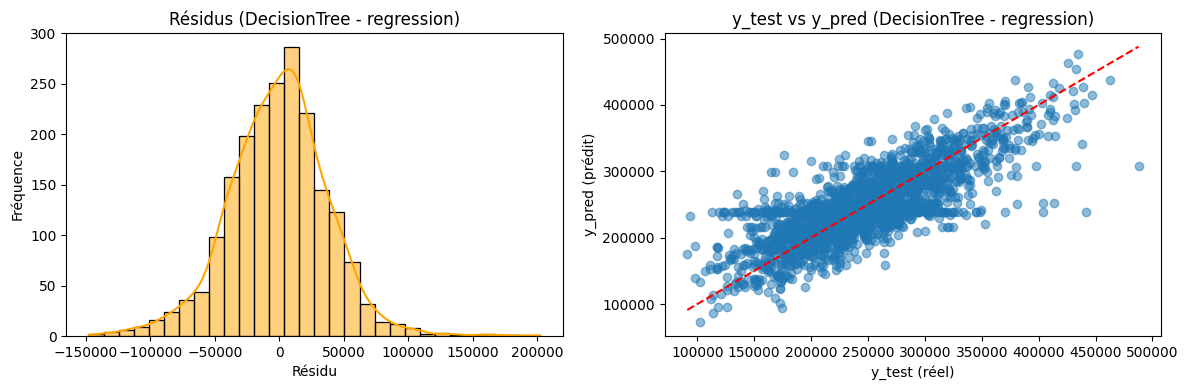

regression | DecisionTree : MAE=29499.98, RMSE=38551.00, R2=0.613


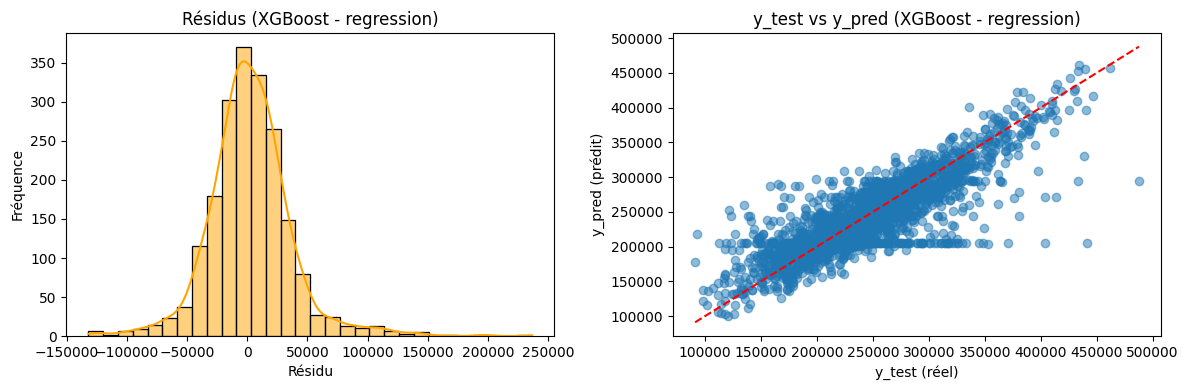

regression | XGBoost : MAE=24550.21, RMSE=34501.35, R2=0.690


In [168]:
scores_knn = regression_evaluation(df_reg, "regression")